In [1]:
import tweepy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re
import numpy as np
from collections import Counter 
from textblob import TextBlob
pd.options.display.max_colwidth = 500

In [2]:
twitter_consumer_key="8diq9Z2yKymfHbgFF6dlLHUaE"
twitter_consumer_secret="RcG2VTx2Hgha5zNPZnJ7HmAoh8bSTbNgvoxSuf5YFo8zZYlaoS"
twitter_access_token="1323272530619228160-ovgY32WoCMxxEmW0ewNQXYUPVJ6rqH"
twitter_access_secret = "9CsC8ZEJDcXngyRE2ThjvgIQOrtBmo9uP7xAqlpPO14lG"

In [3]:
auth = tweepy.OAuthHandler(twitter_consumer_key, twitter_consumer_secret)
auth.set_access_token(twitter_access_token, twitter_access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

# Search by userID

In [4]:
def get_user_tweets(userID, k):
    tweets_list = []
    tweets = tweepy.Cursor(
        api.user_timeline, 
        id=userID, 
        lang="en", 
        tweet_mode='extended',
        count=k,
        include_rts = 0
    ).items(k)

    for tweet in tweets:
            full_text_retweeted = tweet._json.get("retweeted_status")
            if full_text_retweeted != None:
                tweets_list.append([tweet.id_str, 
                      tweet.created_at, 
                      tweet.favorite_count, 
                      tweet.retweet_count, 
                      tweet.user.name,
                      full_text_retweeted.get("full_text")])
            else:
                tweets_list.append([tweet.id_str, 
                      tweet.created_at, 
                      tweet.favorite_count, 
                      tweet.retweet_count, 
                      tweet.user.name,
                      tweet._json["full_text"]])
    df = pd.DataFrame(tweets_list, columns=["id","created_at","favorite_count","retweet_count","user","full_text"])
    df.to_csv(userID + ".csv") #save to a file

We decided to analyze Subway, Pizza Hut and Burger King tweets. All of them are brands well known all over the world. Subway and Pizza Hut have similar number of tweets in November. On the other hand, Burger King will be interesting in case of sentiment analysis.

In [5]:
# get_user_tweets("SUBWAY", k=1000)

In [6]:
# get_user_tweets("pizzahut", k=1000)

In [7]:
# get_user_tweets("BurgerKing", k=1000)

**Let's analyze all datasets**

SUBWAY tweets dataset

In [36]:
su = pd.read_csv("SUBWAY.csv",index_col=0)
su.created_at = pd.to_datetime(su.created_at, format="%Y/%m/%d")
su.head(3)

id          created_at  favorite_count  retweet_count  \
0  1327001436157308928 2020-11-12 21:32:51               1              0   
1  1327001374819835909 2020-11-12 21:32:36               1              0   
2  1327001308835041280 2020-11-12 21:32:21               0              0   

      user                              full_text  
0  Subway®  @HAPPYHONGO1 that is very nice of you  
1  Subway®            @uxmb_ this is a no brainer  
2  Subway®              @frugil2 goodnight friend

Pizza Hut tweets dataset

In [9]:
ph = pd.read_csv("pizzahut.csv",index_col=0)
ph.created_at = pd.to_datetime(ph.created_at, format="%Y/%m/%d")
ph.head(3)

id          created_at  favorite_count  retweet_count  \
0  1327030910672244736 2020-11-12 23:29:58               0              0   
1  1327022733327097856 2020-11-12 22:57:29               1              0   
2  1327022196938600448 2020-11-12 22:55:21               0              0   

       user  \
0  PizzaHut   
1  PizzaHut   
2  PizzaHut   

                                                                                                                                     full_text  
0  @Mr_ARChapman This pizza needs some help! Would you mind sending us a private message so we can see what we can do? https://t.co/PQtSXiQxeo  
1                                                                                                              @KatrinaCol18 What a beauty! 😍👍  
2                                       @danftj Sorry for the delay. Mind sending us a DM so we can follow up on this? https://t.co/PQtSXiQxeo

Burger King tweets dataset

In [10]:
bk = pd.read_csv("BurgerKing.csv",index_col=0)
bk.created_at = pd.to_datetime(bk.created_at, format="%Y/%m/%d")
bk.head(3)

id          created_at  favorite_count  retweet_count  \
0  1327015817930797058 2020-11-12 22:30:00               0              0   
1  1326999078237036547 2020-11-12 21:23:29               0              0   
2  1326990537006657536 2020-11-12 20:49:32               0              0   

          user  \
0  Burger King   
1  Burger King   
2  Burger King   

                                                                                                                                                       full_text  
0   @BarstowRacing Hey there, Mark, thanks for bringing this to our attention. Please contact us at our support page so we can help out https://t.co/mSuvcV4xgm.  
1                                                                                                                                    @Gerrrr_ege we sell burgers  
2  @gerhewitt1 We understand the gravity of this situation, Gerry. Please DM us with your contact info and the store location, so we can look into this for you.

**First we want only tweets from November**

In [37]:
su1 = su[su['created_at']>pd.Timestamp(year=2020, month=11, day=1, hour=0)].copy()
su1.shape

(892, 6)

In [38]:
ph1 = ph[ph['created_at']>pd.Timestamp(year=2020, month=11, day=1, hour=0)].copy()
ph1.shape

(963, 6)

In [39]:
bk1 = bk[bk['created_at']>pd.Timestamp(year=2020, month=11, day=1, hour=0)].copy()
bk1.shape

(258, 6)

**Are there hashtags in our datasets?**

In [14]:
hashtags=[]
for i in range(len(su1['full_text'])):
    if "#" in su1['full_text'][i]:
        hashtags.append(su1['full_text'][i])
hashtags

['@Chargers @Keenan13Allen that’s what we’re talkin’ about! $100k to NFL #PLAY60 for the double-down! #FootlongShuffle',
 '@RaginRoid #FootlongShuffle',
 'We see you @Keenan13Allen with ANOTHER #FootlongShuffle! We’re making that $100k to NFL #PLAY60! #BoltUp',
 '@NFL @Keenan13Allen That’s the second #FootlongShuffle for @Keenan13Allen! We’re making that $100k to NFL #PLAY60!',
 'Who schedules these things? #NationalSandwichDay']

In [15]:
hashtags=[]
for i in range(len(ph1['full_text'])):
    if "#" in ph1['full_text'][i]:
        hashtags.append(ph1['full_text'][i])
hashtags

['Truth is, our NEW Beyond Italian Sausage Pizza is made of plant-based Italian sausage. We dared @KevinHart4real to taste it and tell us what he thinks. One dare led to another…👀 😋. Get it for a limited time! #beyondambassador @BeyondMeat https://t.co/CNWaVEa9oy']

In [16]:
hashtags=[]
for i in range(len(bk1['full_text'])):
    if "#" in bk1['full_text'][i]:
        hashtags.append(bk1['full_text'][i])
hashtags

[]

We can see that chosen twitter users do not use many hashtags in their tweets. In November Subway used hashtags in 5 tweets, Pizza Hut only in 1 and Burger King did not use any. 

Subway used hashtags #FootlongShuffle, #PLAY60!, #BoltUp and #NationalSandwichDay. 

Pizza Hut used #beyondambassador.

**Most common words**

In [17]:
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
stopword = nltk.corpus.stopwords.words('english')

In [18]:
def common_words(data,n):
    tweets=[]
    for tweet in data:
        tweet = re.sub(' us ', "", tweet)
        tweets.append(tweet.capitalize())
    text_cleaned_tokenized = []
    for text in tweets:
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)
        text_cleaned_tokenized.append([word for word in word_tokenize(text) if (word not in stopword and word.isalpha())])
    words=[]
    for item in text_cleaned_tokenized:
        words.extend(item)
    word_count = Counter(words)
    return word_count.most_common(n)

In [19]:
print('The most common words for Subway tweets are:')
common_words(su1['full_text'],10)

The most common words for Subway tweets are:


[('sandwiches', 51),
 ('sandwich', 38),
 ('get', 34),
 ('know', 32),
 ('us', 32),
 ('got', 27),
 ('good', 27),
 ('one', 26),
 ('like', 26),
 ('subs', 26)]

In [20]:
print('The most common words for Pizza Hut tweets are:')
common_words(ph1['full_text'],10)

The most common words for Pizza Hut tweets are:


[('mind', 344),
 ('sendinga', 276),
 ('address', 236),
 ('dm', 206),
 ('store', 190),
 ('thanks', 143),
 ('would', 127),
 ('private', 97),
 ('message', 97),
 ('reaching', 93)]

In [21]:
print('The most common words for Burger King tweets are:')
common_words(bk1['full_text'],10)

The most common words for Burger King tweets are:


[('please', 156),
 ('name', 116),
 ('location', 100),
 ('contact', 94),
 ('thank', 94),
 ('look', 93),
 ('dmyour', 93),
 ('store', 89),
 ('full', 81),
 ('info', 80)]

From analysis of the most common words we can deduce what type of tweets the observed fastfoods' accounts post. In Subway case we can see that most common words are "sandwiches", so we can assume that most of their posts are advertisement of their products. Pizza Hut and Burger King, except of advertising their products, use tweets to contact customers. It can be deduced from use of words like "address, private, message, please, contact".

**Favorite_count and retweet_count in time**

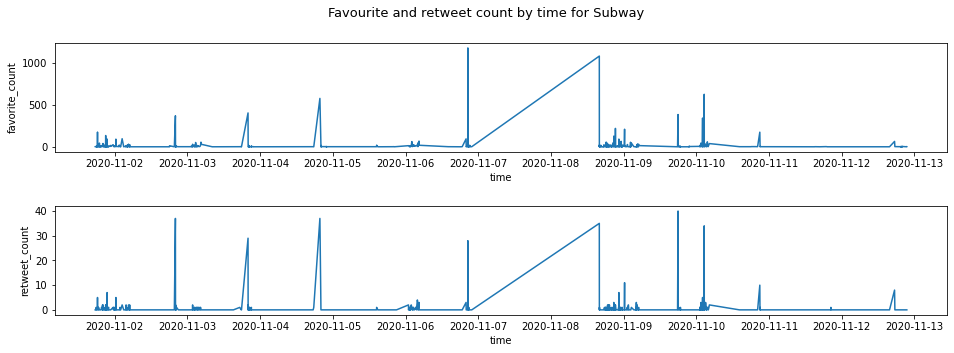

In [22]:
ylabels = ["favorite_count","retweet_count"]

fig = plt.figure(figsize=(16,5))
fig.subplots_adjust(hspace=0.5,wspace=0.01)
years = mdates.DayLocator()

n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(su1["created_at"],su1[ylabel])
    ax.xaxis.set_major_locator(years)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("time")
fig.suptitle("Favourite and retweet count by time for Subway", fontsize=13)
plt.show()

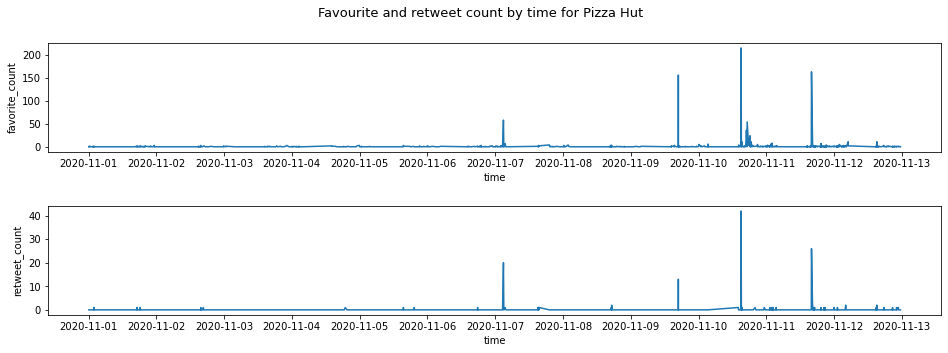

In [23]:
ylabels = ["favorite_count","retweet_count"]

fig = plt.figure(figsize=(16,5))
fig.subplots_adjust(hspace=0.5,wspace=0.01)
years = mdates.DayLocator()

n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(ph1["created_at"],ph1[ylabel])
    ax.xaxis.set_major_locator(years)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("time")
fig.suptitle("Favourite and retweet count by time for Pizza Hut", fontsize=13)
plt.show()

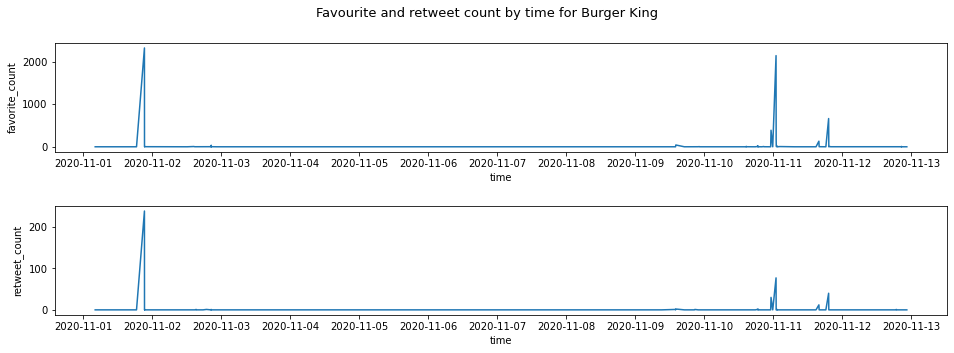

In [24]:
ylabels = ["favorite_count","retweet_count"]

fig = plt.figure(figsize=(16,5))
fig.subplots_adjust(hspace=0.5,wspace=0.01)
years = mdates.DayLocator()

n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(bk1["created_at"],bk1[ylabel])
    ax.xaxis.set_major_locator(years)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("time")
fig.suptitle("Favourite and retweet count by time for Burger King", fontsize=13)
plt.show()

 <br>
Now we want to check the peaks which are on the plots above.

In [25]:
su1.sort_values(by='favorite_count')[len(su1)-3:]

id          created_at  favorite_count  retweet_count  \
109  1325991239418834950 2020-11-10 02:38:41             625             34   
431  1325468120585211904 2020-11-08 16:00:00            1080             35   
462  1324812628305334273 2020-11-06 20:35:19            1177             28   

        user  \
109  Subway®   
431  Subway®   
462  Subway®   

                                                                                                                                           full_text  
109  @barstoolsports e·lite\n/əˈlēt,āˈlēt/\n\n1. a select group that is superior in terms of ability or qualities to the rest of a group or society.  
431                    oh no we just heard from your favorite team and they said they’ll lose today if you don’t get Footlongs while you watch yikes  
462                                                                               heard you were liking our Magic 8 Bills, heard we have a few more…

In [26]:
ph1.sort_values(by='favorite_count')[len(ph1)-3:]

id          created_at  favorite_count  retweet_count  \
471  1325843381570985988 2020-11-09 16:51:09             156             13   
231  1326555359201341441 2020-11-11 16:00:18             163             26   
396  1326178888481972224 2020-11-10 15:04:20             215             42   

         user  \
471  PizzaHut   
231  PizzaHut   
396  PizzaHut   

                                                                                                                                                                                                                                                                 full_text  
471                                                                                                                                                                                    Nothing is as it seems. You have to taste it to believe it. https://t.co/yNnIAYpUwh  
231                                                                                                                             Swipe and you’ll miss it. Get your hands on the NEW Beyond Italian Sausage Pizza. Only at Pizza Hut. 🤗 @BeyondMeat https://t.co/La8ARFF58W  
396  Truth is, our NEW Beyond Italian Sausage Pizza is made of plant-based Italian sausage. We dared @KevinHart4real to taste it and tell us what he thinks. One dare led to another…👀 😋. Get it for a limited time! #beyondambassador @BeyondMeat https://t.co/CNWaVEa9oy

In [27]:
bk1.sort_values(by='favorite_count')[len(bk1)-3:]

id          created_at  favorite_count  retweet_count  \
32   1326605045606068224 2020-11-11 19:17:44             662             40   
53   1326328799957450753 2020-11-11 01:00:02            2138             77   
218  1323010762965716994 2020-11-01 21:15:20            2318            238   

            user  \
32   Burger King   
53   Burger King   
218  Burger King   

                                                                                                                                                                                  full_text  
32   aliens exist.\n\nok, now that we got your attention, it’s Wednesday, which means you can go cop a $1 Whopper this Wednesday. \n\n(U.S. only on the BK® app or https://t.co/tWSdfUbbGu)  
53                                                                                                                                     on a scale of 1 to chicken fries, how‘d your day go?  
218                                                                                                                                   theres no such thing as “too soon” for holiday music.

We can see that for all datasets the most favorite and retweeted tweets are advertisements of products. Subway has much more retweeted tweets which proves that previous assumption about type of their posts was reasonable. 

**Now let's analyze the sentiment of tweets.**

In [28]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [29]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [40]:
su1.loc[:,'Subjectivity'] = su1['full_text'].apply(getSubjectivity).copy()
su1.loc[:,'Polarity'] = su1['full_text'].apply(getPolarity).copy()

In [41]:
ph1.loc[:,'Subjectivity'] = ph1['full_text'].apply(getSubjectivity).copy()
ph1.loc[:,'Polarity'] = ph1['full_text'].apply(getPolarity).copy()

In [42]:
bk1.loc[:,'Subjectivity'] = bk1['full_text'].apply(getSubjectivity).copy()
bk1.loc[:,'Polarity'] = bk1['full_text'].apply(getPolarity).copy()

In [43]:
su1.head(1)

id          created_at  favorite_count  retweet_count  \
0  1327001436157308928 2020-11-12 21:32:51               1              0   

      user                              full_text  Subjectivity  Polarity  
0  Subway®  @HAPPYHONGO1 that is very nice of you           1.0      0.78

In [44]:
ph1.head(1)

id          created_at  favorite_count  retweet_count  \
0  1327030910672244736 2020-11-12 23:29:58               0              0   

       user  \
0  PizzaHut   

                                                                                                                                     full_text  \
0  @Mr_ARChapman This pizza needs some help! Would you mind sending us a private message so we can see what we can do? https://t.co/PQtSXiQxeo   

   Subjectivity  Polarity  
0         0.375       0.0

In [45]:
bk1.head(1)

id          created_at  favorite_count  retweet_count  \
0  1327015817930797058 2020-11-12 22:30:00               0              0   

          user  \
0  Burger King   

                                                                                                                                                      full_text  \
0  @BarstowRacing Hey there, Mark, thanks for bringing this to our attention. Please contact us at our support page so we can help out https://t.co/mSuvcV4xgm.   

   Subjectivity  Polarity  
0           0.2       0.2

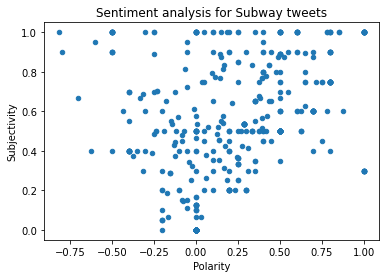

In [46]:
su1.plot.scatter(x="Polarity",y="Subjectivity")
plt.title("Sentiment analysis for Subway tweets");

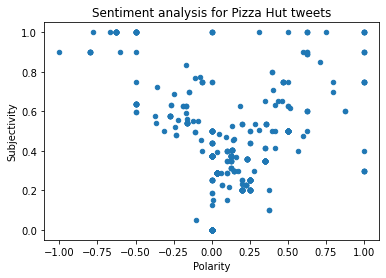

In [47]:
ph1.plot.scatter(x="Polarity",y="Subjectivity")
plt.title("Sentiment analysis for Pizza Hut tweets");

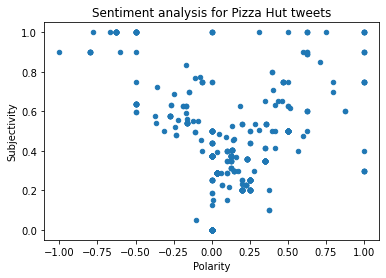

In [48]:
ph1.plot.scatter(x="Polarity",y="Subjectivity")
plt.title("Sentiment analysis for Pizza Hut tweets");

To calculate polarity and sentiment of the tweets we used TextBlob package. It may not be the most exact tool, that's why some values for Polarity and Subjectivity are the same for different tweets. But it can be sufficient aproximation of reality.

In [49]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [50]:
su1.loc[:,'Analysis'] = su1['Polarity'].apply(getAnalysis).copy()

In [51]:
ph1.loc[:,'Analysis'] = ph1['Polarity'].apply(getAnalysis).copy()

In [52]:
bk1.loc[:,'Analysis'] = bk1['Polarity'].apply(getAnalysis).copy()

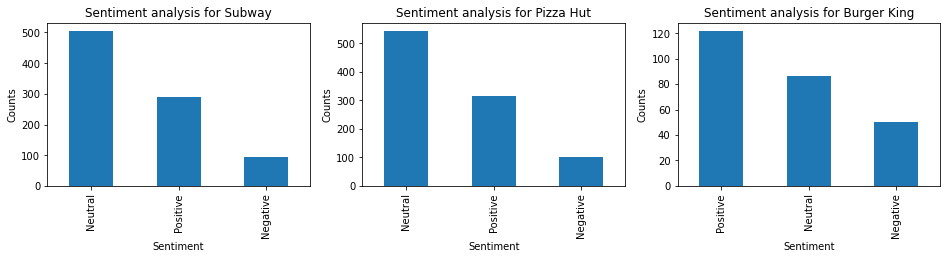

In [53]:
plt.figure(figsize=(16,3))
plt.subplot(131)
plt.title('Sentiment analysis for Subway')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
su1['Analysis'].value_counts().plot.bar()#(kind = 'bar')

plt.subplot(132)
plt.title('Sentiment analysis for Pizza Hut')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
ph1['Analysis'].value_counts().plot(kind = 'bar')

plt.subplot(133)
plt.title('Sentiment analysis for Burger King')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
bk1['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

We can see that Subway and Pizza Hut have similar number of Positive, Negative and Neutral tweets. It proves they are liked fast foods. Interesting is observation of Burger King results. It has majority Positive, but percentage of negative posts is much higher that in case od Subway or Pizza Hut. We checked some tweets and we think their negative sentiment is caused by customers' complaints. 

In [54]:
su1.plot(x="created_at",y='Polarity')
plt.ylabel("Polarity")
plt.xlabel("time")
plt.rcParams["figure.figsize"] = (13,3)
plt.title("Polarity by time for Subway", fontsize=13);

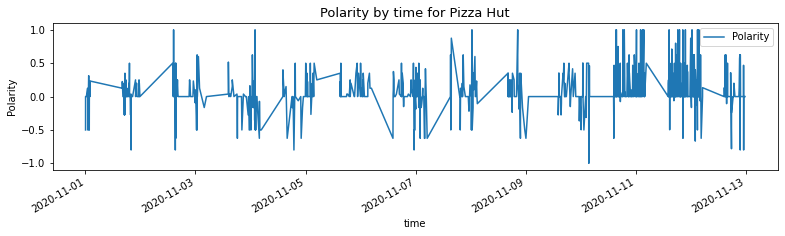

In [55]:
ph1.plot(x="created_at",y='Polarity')
plt.ylabel("Polarity")
plt.xlabel("time")
plt.rcParams["figure.figsize"] = (13,3)
plt.title("Polarity by time for Pizza Hut", fontsize=13);

In [56]:
bk1.plot(x="created_at",y='Polarity')
plt.ylabel("Polarity")
plt.xlabel("time")
plt.rcParams["figure.figsize"] = (13,3)
plt.title("Polarity by time for Burger King", fontsize=13);